In [86]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from cleaning_script import NOMINAL, ORDINAL, CONTINUOUS, DISCRETE

### Read in clean .CSV data

In [87]:
# train
house_train = pd.read_csv('../datasets/house_train_clean.csv')

# test
house_test = pd.read_csv('../datasets/house_test_clean.csv')


### Make DataFrames wide

In [88]:
pd.set_option('display.max_columns', 100)

Modify ORDINAL, NOMINAL, CONTINUOUS and DISCRETE variables based on whatever info we've dropped or kept from the first notebook

In [89]:
ORDINAL = [x for x in ORDINAL if x in house_train.columns]
NOMINAL = [x for x in NOMINAL if x in house_train.columns]
CONTINUOUS = [x for x in CONTINUOUS if x in house_train.columns]
DISCRETE = [x for x in DISCRETE if x in house_train.columns]

# Remove Outliers Based on Z-Score

In [90]:
# remove saleprice outliers 
# house_train[is_outlier(house_train.lot_area)]['saleprice'].describe()

# consider log-transformation instead
# house_train = house_train[~is_outlier(house_train.saleprice)];


# Plot saleprice

<AxesSubplot:ylabel='Frequency'>

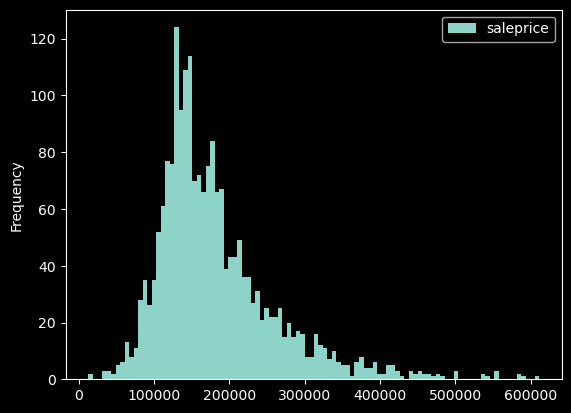

In [91]:
house_train.plot.hist(y='saleprice', bins=100)

# Look for Correlations within Numerical Categories

In [92]:
# create helper function for plotting correlations
corr_vals = {}
def plot_corr_heatmap(CATEGORY, title):
    COLUMNS = [x for x in CATEGORY]
    COLUMNS.append('saleprice')

    fig, ax = plt.subplots(figsize=(20,12))
    corr = house_train[COLUMNS].corr()
    
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))
    plt.title(f'{title} Correlations')
    
    return sns.heatmap(corr, mask=mask, annot=True), corr['saleprice']

# dictionary of correlative factors
correlative_factors = {}

### Discrete

In [93]:
DISCRETE


['year_built',
 'year_remod/add',
 'bsmt_full_bath',
 'bsmt_half_bath',
 'full_bath',
 'half_bath',
 'bedroom_abvgr',
 'kitchen_abvgr',
 'totrms_abvgrd',
 'fireplaces',
 'garage_yr_blt',
 'garage_cars',
 'mo_sold',
 'yr_sold']

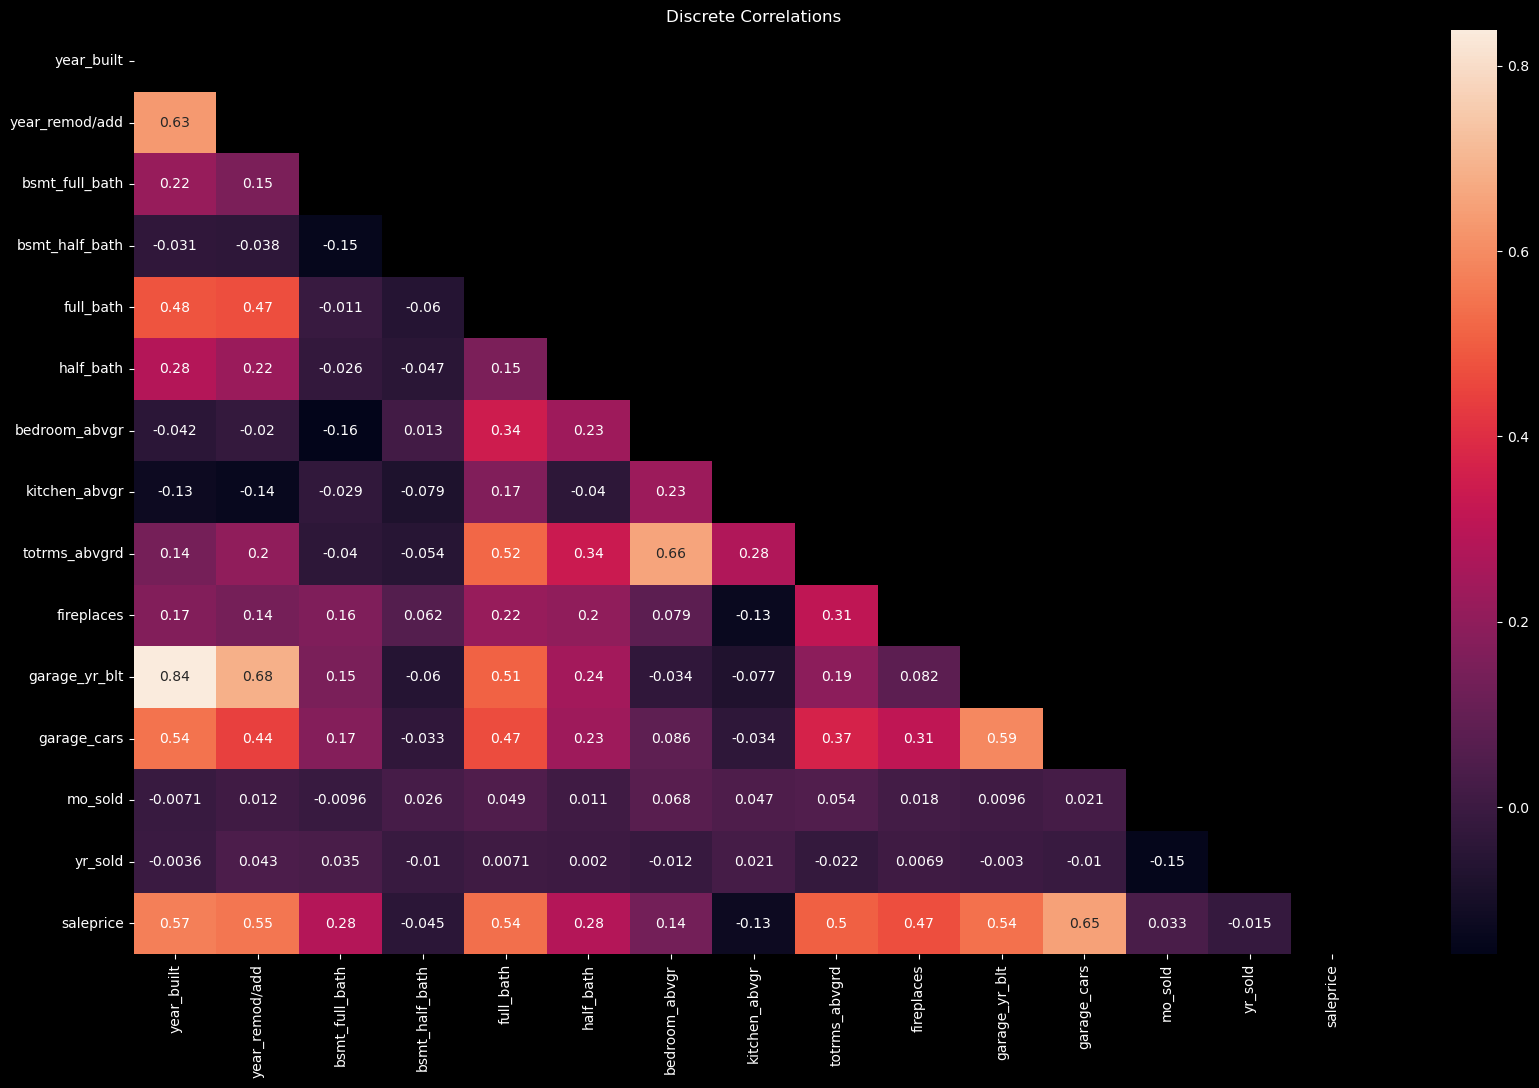

In [94]:
discrete_corrs = plot_corr_heatmap(DISCRETE, 'Discrete')

correlative_factors.update(discrete_corrs[1].to_dict())

### Continous

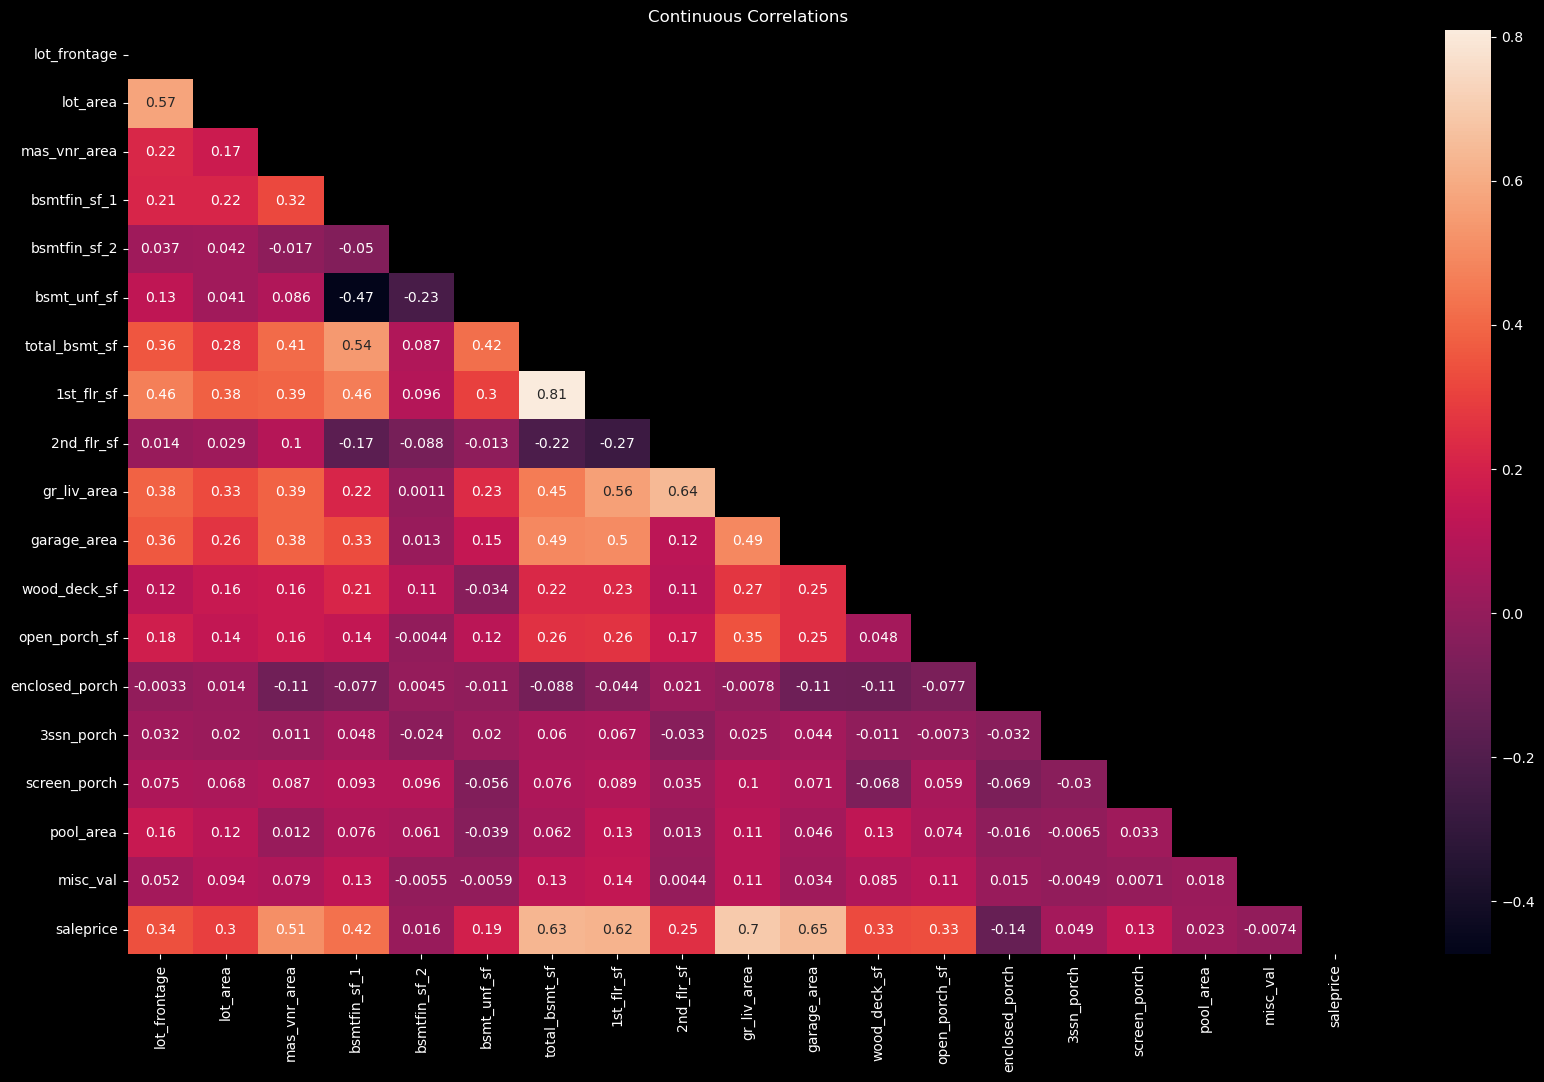

In [95]:
continuous_corrs = plot_corr_heatmap(CONTINUOUS, 'Continuous')

correlative_factors.update(continuous_corrs[1].to_dict())

### Ordinal

Theres clearly a lot of value in these ranked qualitative values, we'll make them numeric and see if we can get some more value. 

       
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor

The following columns use this system:  
- exter_qual
- exter_cond
- bsmt_qual
- bsmt_cond
- bsmt_exposure
- heating_qc
- kitchen_qual
- garage_qual
- garage_cond

In [96]:
# functions to rank Ordinal quality ratings
def ordinal_to_numeric_expo(val):
    if val == 'Ex':
        return 4
    elif val == 'Gd':
        return 3
    elif val == 'TA':
        return 2
    elif val == 'Fa':
        return 1
    elif val == 'Po':
        return 0
    else:
        pass

def ordinal_to_numeric_glqna(val):
    if val == 'GLQ':
        return 6
    elif val == 'ALQ':
        return 5
    elif val == 'BLQ':
        return 4
    elif val == 'Rec':
        return 3
    elif val == 'LwQ':
        return 2
    elif val == 'Unf':
        return 1
    elif val == 'NA':
        return 0
    else:
        pass

def ordinal_to_numeric_functional(val):
    if val == 'Typ':
        return 3
    elif val == 'Min1':
        return 2
    elif val == 'Min2':
        return 1
    elif val == 'Mod':
        return 0
    elif val == 'Maj1':
        return -1
    elif val == 'Maj2':
        return -2
    elif val == 'Sev':
        return -3
    elif val == 'Sal':
        return -4
    else:
        pass

Find the columns that use the 'Ex - Po' rating schema

In [97]:
def ex_po(df):
    rank_words = ['Ex', 'Gd', 'TA','Fa', 'Po']
    rank_words = pd.Series(rank_words)
    columns_to_fix = []

# find columns, append to columns to fix
    for col in df[ORDINAL].columns:
        word_check = rank_words.isin(df[ORDINAL][col])
        if word_check.sum() > 0:
            columns_to_fix.append(col)
            
# convert columns to numeric values
    for col in columns_to_fix:
        df[col] = [ordinal_to_numeric_expo(val) for val in df[col]]

In [98]:
# expo train
ex_po(house_train)
# expo test
ex_po(house_test)

Basements

In [99]:
def glqna(df):
    basement_cols = ['bsmtfin_type_1', 'bsmtfin_type_2']

    for col in basement_cols:
        df[col] = [ordinal_to_numeric_glqna(val) for val in df[col]]

In [100]:
# glqna train
glqna(house_train)
# glqna test
glqna(house_test)

Functional

In [101]:
def functional(df):
    df['functional'] = [ordinal_to_numeric_functional(val) for val in df['functional']]

In [102]:
# functional train
functional(house_train)
# functional test
functional(house_test)

In [103]:
house_train [ORDINAL].house_style.unique()

array(['2Story', '1Story', '1.5Fin', 'SFoyer', 'SLvl', '2.5Unf', '2.5Fin',
       '1.5Unf'], dtype=object)

Ordinal Correlations

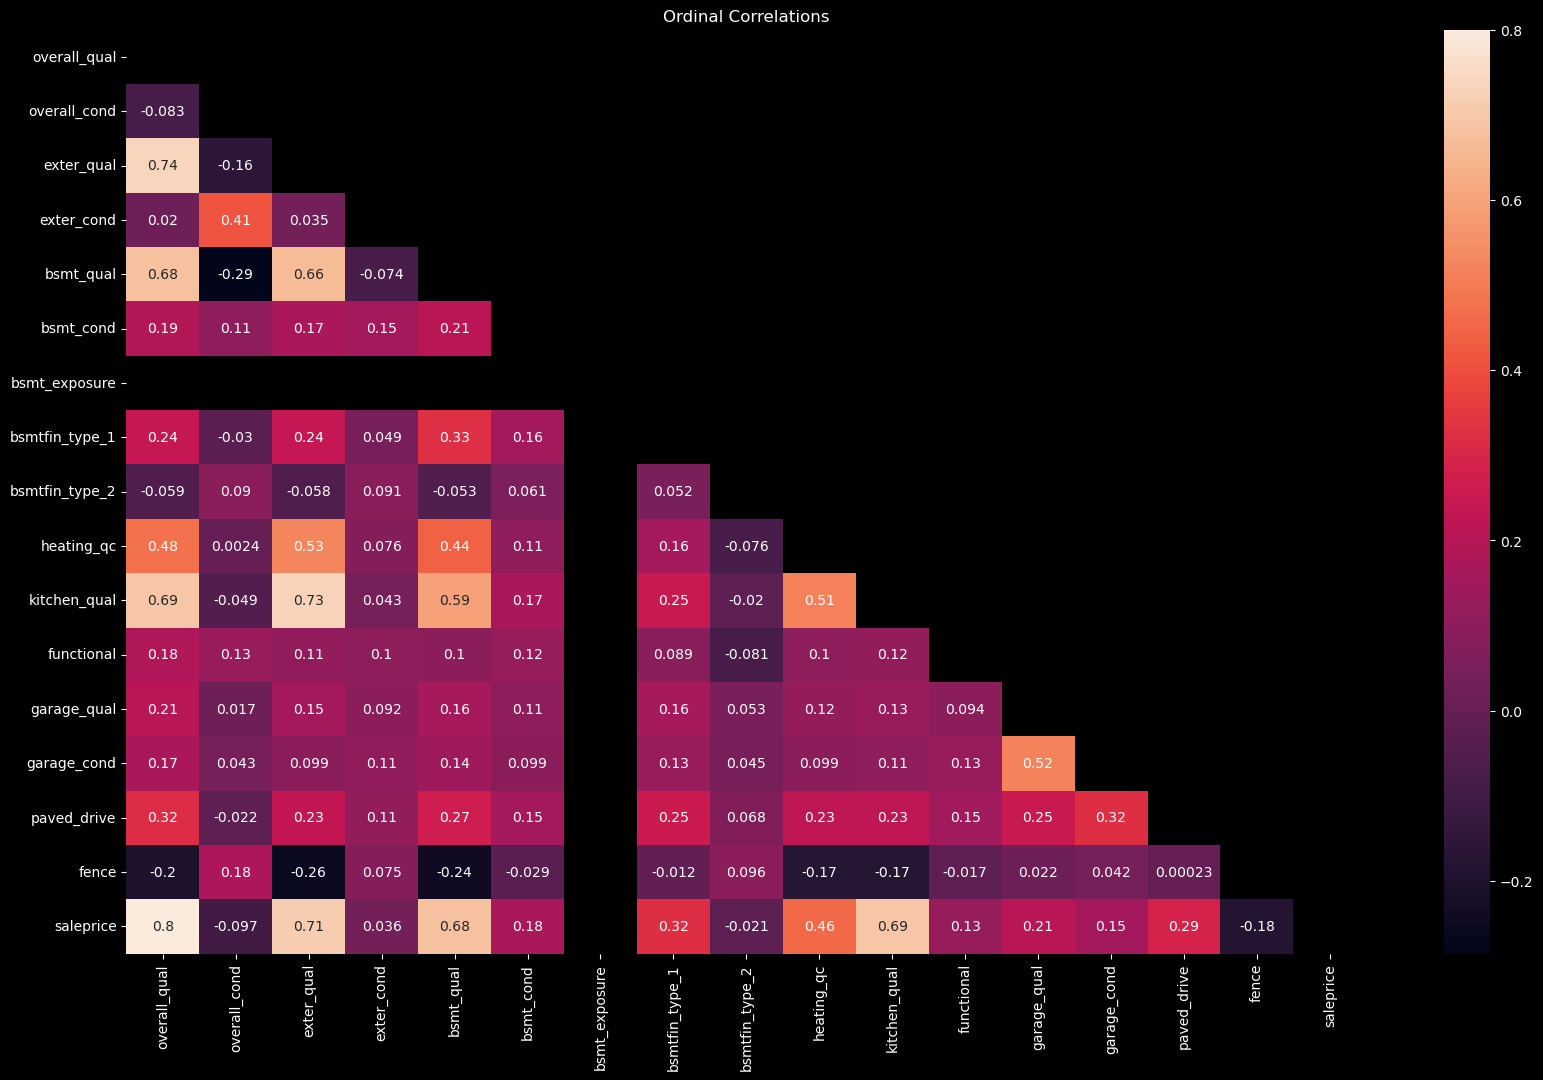

In [104]:
ordinal_corrs = plot_corr_heatmap(ORDINAL, 'Ordinal')

correlative_factors.update(ordinal_corrs[1].to_dict())

### Nominal

Condition 1 (Nominal): Proximity to various conditions
	
       Artery	Adjacent to arterial street
       Feedr	Adjacent to feeder street	
       Norm	Normal	
       RRNn	Within 200' of North-South Railroad
       RRAn	Adjacent to North-South Railroad
       PosN	Near positive off-site feature--park, greenbelt, etc.
       PosA	Adjacent to postive off-site feature
       RRNe	Within 200' of East-West Railroad
       RRAe	Adjacent to East-West Railroad
	
Condition 2 (Nominal): Proximity to various conditions (if more than one is present)
		
       Artery	Adjacent to arterial street
       Feedr	Adjacent to feeder street	
       Norm	Normal	
       RRNn	Within 200' of North-South Railroad
       RRAn	Adjacent to North-South Railroad
       PosN	Near positive off-site feature--park, greenbelt, etc.
       PosA	Adjacent to postive off-site feature
       RRNe	Within 200' of East-West Railroad
       RRAe	Adjacent to East-West Railroad

These seem important! location, location, location. Let's make them numerical too. 

Location Dummies

In [105]:
# get conditions dummies and concat
# train
house_train = pd.concat([house_train, pd.get_dummies(house_train['condition_1'])], axis=1)
# test
house_test = pd.concat([house_test, pd.get_dummies(house_test['condition_1'])], axis=1)

# add dummy columns back to NOMINAL so we can call it below
for x in pd.get_dummies(house_train['condition_1']).columns.to_list():
    NOMINAL.append(x)

Utility Dummies

In [106]:
# get conditions dummies and concat
# train
house_train = pd.concat([house_train, pd.get_dummies(house_train['utilities'])], axis=1)
# test
house_test = pd.concat([house_test, pd.get_dummies(house_test['utilities'])], axis=1)

# add dummy columns back to NOMINAL so we can call it below
for x in pd.get_dummies(house_train['utilities']).columns.to_list():
    NOMINAL.append(x)

Roof Dummies

In [107]:
# get conditions dummies and concat
# train
house_train = pd.concat([house_train, pd.get_dummies(house_train['roof_matl'])], axis=1)
# test
house_test = pd.concat([house_test, pd.get_dummies(house_test['roof_matl'])], axis=1)

# add dummy columns back to NOMINAL so we can call it below
for x in pd.get_dummies(house_train['roof_matl']).columns.to_list():
    NOMINAL.append(x)

Foundation Dummies

In [108]:
# get conditions dummies and concat
# train
house_train = pd.concat([house_train, pd.get_dummies(house_train['foundation'])], axis=1)
# test
house_test = pd.concat([house_test, pd.get_dummies(house_test['foundation'])], axis=1)

# add dummy columns back to NOMINAL so we can call it below
for x in pd.get_dummies(house_train['foundation']).columns.to_list():
    NOMINAL.append(x)

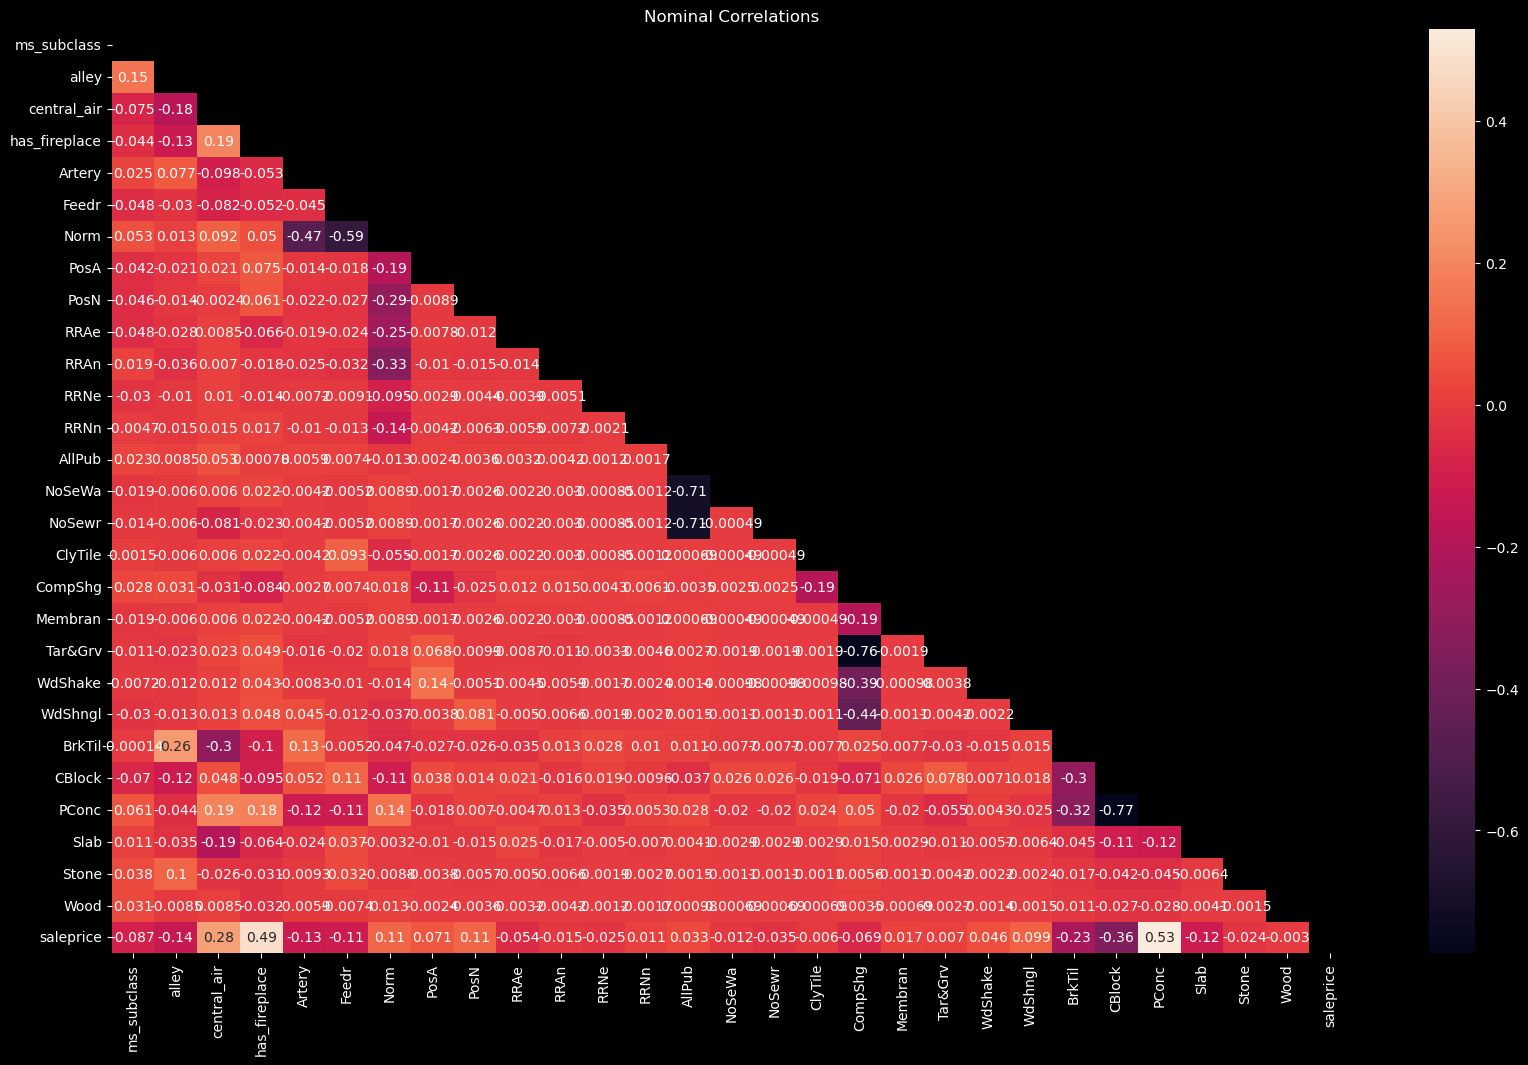

In [109]:
nominal_corrs = plot_corr_heatmap(NOMINAL, 'Nominal')

correlative_factors.update(nominal_corrs[1].to_dict())

'Norm' 'PosA' and 'PosN' have a weak positive correlative effect and being near a railroad or busy thruway has a weak negative correlative effect

# Find Most Correlative Factors
- Gives us a place to start building new features from

In [110]:
correlative_factors.pop('saleprice', None)

1.0

In [111]:
correlative_factors = {k:v for k,v in correlative_factors.items() if np.abs(v) > .1 and k != 'saleprice'}

# correlative_factors.pop('saleprice')

In [112]:
correlative_factors

{'year_built': 0.5718488959135766,
 'year_remod/add': 0.550369648819556,
 'bsmt_full_bath': 0.28366171790104494,
 'full_bath': 0.5379691021121237,
 'half_bath': 0.28300069798833244,
 'bedroom_abvgr': 0.1370669364676557,
 'kitchen_abvgr': -0.12544352246857687,
 'totrms_abvgrd': 0.5040143180735323,
 'fireplaces': 0.47109289376298785,
 'garage_yr_blt': 0.540931494364549,
 'garage_cars': 0.648220264945595,
 'lot_frontage': 0.34184248372687115,
 'lot_area': 0.2965658323667791,
 'mas_vnr_area': 0.512229843025336,
 'bsmtfin_sf_1': 0.4235188008998825,
 'bsmt_unf_sf': 0.1902097445963745,
 'total_bsmt_sf': 0.628924705734454,
 '1st_flr_sf': 0.6184861410533949,
 '2nd_flr_sf': 0.2484515301311421,
 'gr_liv_area': 0.6970384443056613,
 'garage_area': 0.6502700352166242,
 'wood_deck_sf': 0.3264897021896556,
 'open_porch_sf': 0.3334760297920542,
 'enclosed_porch': -0.13565649182472073,
 'screen_porch': 0.1345813519622582,
 'overall_qual': 0.8002068702531393,
 'exter_qual': 0.7121457238137716,
 'bsmt_qua

# Missing Value Imputation for Correlative Factors

In [113]:
missing_train = house_train[correlative_factors.keys()].isnull().sum().sort_values(ascending = False).loc[lambda x: x > 0]

missing_test = house_test[correlative_factors.keys()].isnull().sum().sort_values(ascending = False).loc[lambda x: x > 0]

print(missing_train)
print('*' * 50)
print(missing_test)

lot_frontage      330
garage_qual       114
garage_cond       114
garage_yr_blt     114
bsmtfin_type_1     55
bsmt_cond          55
bsmt_qual          55
mas_vnr_area       22
bsmt_full_bath      2
garage_area         1
total_bsmt_sf       1
bsmtfin_sf_1        1
bsmt_unf_sf         1
garage_cars         1
dtype: int64
**************************************************
lot_frontage      160
garage_qual        45
garage_cond        45
garage_yr_blt      45
bsmt_qual          25
bsmt_cond          25
bsmtfin_type_1     25
mas_vnr_area        1
dtype: int64


`lot_frontage`

<AxesSubplot:title={'center':'After Missing Values Filled'}, ylabel='Frequency'>

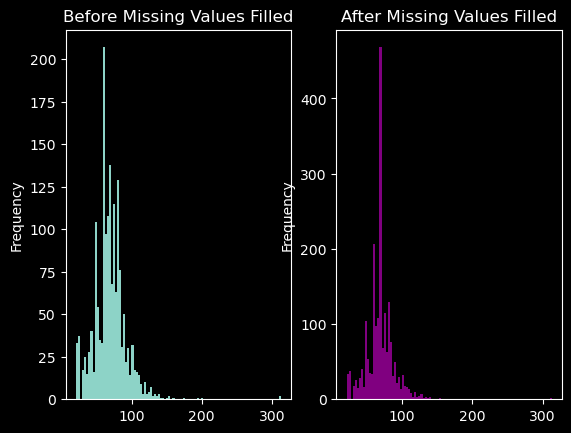

In [114]:
before = house_train['lot_frontage'].copy()

# median is 67, mean is 68, impute with mean
# train
house_train['lot_frontage'].fillna(house_train['lot_frontage'].mean(), inplace = True)
# test
house_test['lot_frontage'].fillna(house_test['lot_frontage'].mean(), inplace = True)

fig, axes = plt.subplots(1,2)

before.plot.hist(bins=100, ax = axes[0], title='Before Missing Values Filled')
house_train['lot_frontage'].plot.hist(bins=100, ax = axes[1], color = 'purple', title = 'After Missing Values Filled')

`mas_vnr_area`

<AxesSubplot:title={'center':'After Missing Values Filled'}, ylabel='Frequency'>

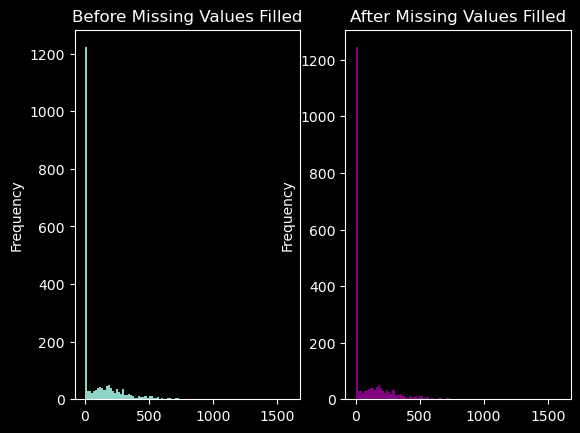

In [115]:
before = house_train['mas_vnr_area'].copy()

# train
house_train['mas_vnr_area'].fillna(0, inplace=True) # 0 is the mode, overwhelmingly the case
# test
house_test['mas_vnr_area'].fillna(0, inplace = True)

fig, axes = plt.subplots(1,2)

before.plot.hist(bins=100, ax = axes[0], title='Before Missing Values Filled')
house_train['mas_vnr_area'].plot.hist(bins=100, ax = axes[1], color = 'purple', title = 'After Missing Values Filled')

`bsmtfin_type_1`

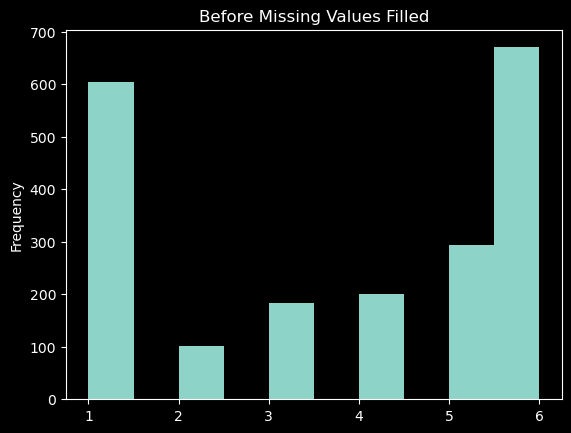

In [116]:
def random_bsmt_imputation(df):
    weights = []
# find distribution of scores amongst the values have aren't NaN, append proportions to weights
    for x in range(1,7):
        weights.append(
        len(df.query(f'bsmtfin_type_1 == {x} and bsmtfin_type_1.notna()'))/
        len(df.query(f'bsmtfin_type_1.notna()'))
        )

# use proportions as probability weights for random assignment of values
    df['bsmtfin_type_1'].fillna(np.random.choice(np.arange(1,7), p=weights), inplace=True)

# train
random_bsmt_imputation(house_train)
# test
random_bsmt_imputation(house_test)


before = house_train['bsmtfin_type_1'].plot.hist(title='Before Missing Values Filled')

`bsmt_full_bath`

In [117]:
house_train.bsmt_full_bath.describe()

count    2049.000000
mean        0.427526
std         0.522673
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         3.000000
Name: bsmt_full_bath, dtype: float64

<AxesSubplot:title={'center':'Before Missing Values Filled'}, ylabel='Frequency'>

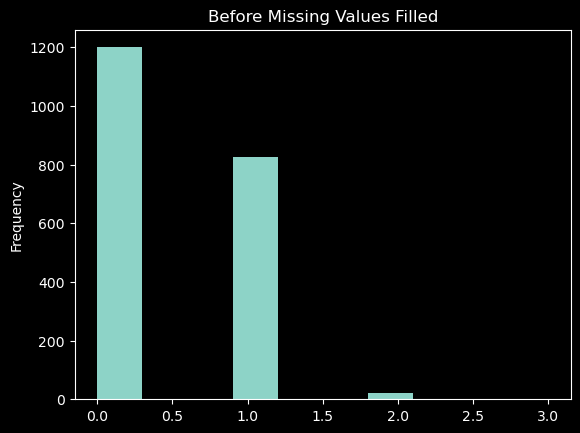

In [118]:

def random_bathroom_imputation(df):
    weights = []
# find distribution of scores amongst the values have aren't NaN, append proportions to weights
    for x in range(0,3):
        weights.append(
        len(df.query(f'bsmt_full_bath == {x} and bsmt_full_bath.notna()'))/
        len(df.query(f'bsmt_full_bath.notna()'))
        )

# normalize so numpy doesn't flag .9998 as not being 1.0
    weights = np.array(weights)
    weights /= weights.sum()

# use proportions as probability weights for random assignment of values
    df['bsmt_full_bath'].fillna(np.random.choice(np.arange(0,3), p=weights), inplace=True)
    
# train
random_bathroom_imputation(house_train)
# test
random_bathroom_imputation(house_test)

house_train.bsmt_full_bath.plot.hist(title = 'Before Missing Values Filled')

`bsmtfin_sf_1`

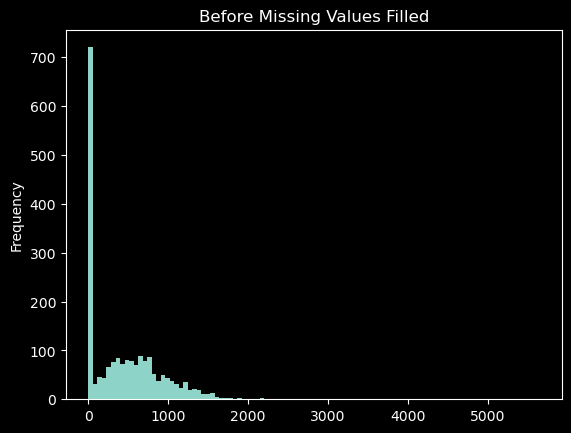

In [119]:
house_train.bsmtfin_sf_1.plot.hist(title='Before Missing Values Filled', bins=100)

# train
house_train['bsmtfin_sf_1'].fillna(0, inplace=True) # 0 is the mode, overwhelmingly the case
# test
house_test['bsmtfin_sf_1'].fillna(0, inplace=True) # 0 is the mode, overwhelmingly the case

`garage_yr_blt`

0    2005.0
Name: garage_yr_blt, dtype: float64


<AxesSubplot:title={'center':'After Missing Values Filled'}, ylabel='Frequency'>

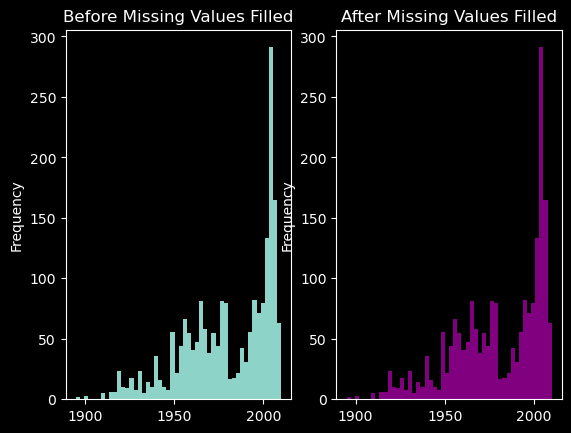

In [120]:

before = house_train['garage_yr_blt']

print(house_train.garage_yr_blt.mode())
# the mean and median for garage_yr_built are all 1978, the mode is 2005
# train
house_train['garage_yr_blt'].fillna(2005, inplace=True)
# test
house_test['garage_yr_blt'].fillna(2005, inplace=True)
fig, axes = plt.subplots(1,2)

before.plot.hist(bins=50, ax = axes[0], title='Before Missing Values Filled')
house_train['garage_yr_blt'].plot.hist(bins=50, ax = axes[1], color = 'purple', title = 'After Missing Values Filled')

`bsmt_qual`

<AxesSubplot:title={'center':'After Missing Values Filled'}, ylabel='Frequency'>

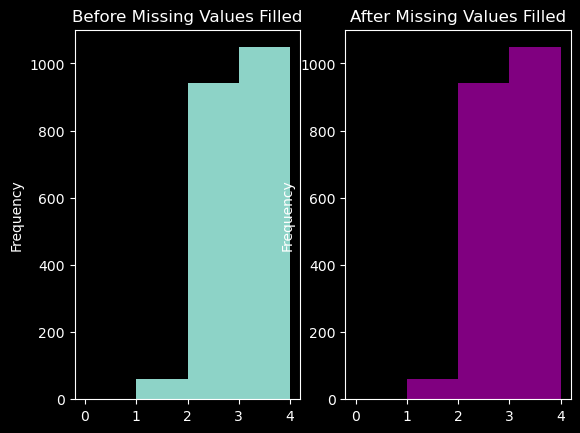

In [121]:
before = house_train['bsmt_qual'] # mode is 2, median is 3, mean is 2.5
# train
house_train['bsmt_qual'].fillna(house_train.bsmt_qual.mean(), inplace=True)
# test
house_test['bsmt_qual'].fillna(house_test.bsmt_qual.mean(), inplace=True)

# plot
fix, axes = plt.subplots(1, 2)
before.plot.hist(bins=4, ax = axes[0], title='Before Missing Values Filled')
house_train['bsmt_qual'].plot.hist(bins=4, ax = axes[1], color = 'purple', title = 'After Missing Values Filled')

`garage_area` and `garage_cars`

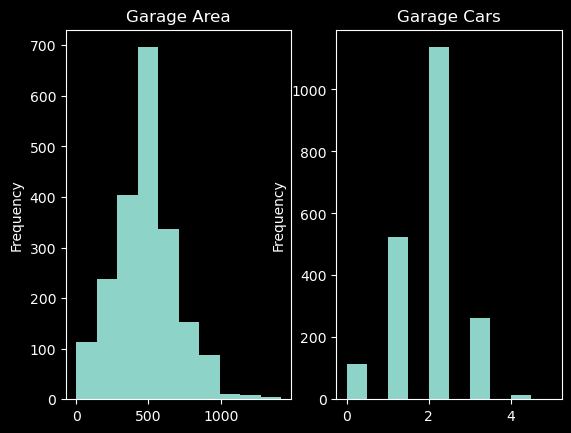

In [122]:
# both of these are just missing 1 value and are close to normally distributed, so we'll insert the median..

fix, axes = plt.subplots(1,2)
house_train.garage_area.plot.hist(title='Garage Area', ax=axes[0])
house_train.garage_cars.plot.hist(title='Garage Cars', ax=axes[1])

for col in ['garage_cars', 'garage_area']:
    house_train[col].fillna(house_train[col].median(), inplace=True)
    house_test[col].fillna(house_test[col].median(), inplace=True)

`total_bsmt_sqft`

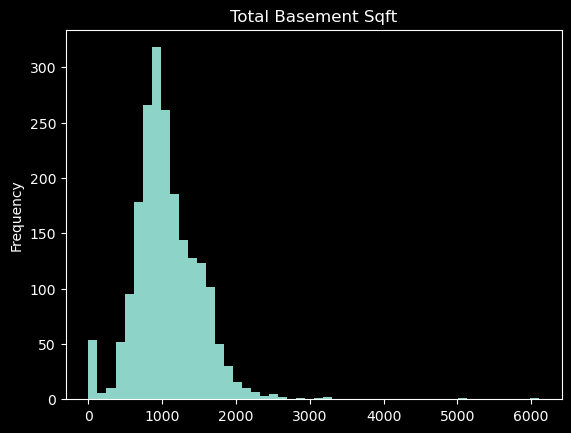

In [123]:
house_train['total_bsmt_sf'].plot.hist(bins=50, title= 'Total Basement Sqft')

house_train['total_bsmt_sf'].fillna(house_train['total_bsmt_sf'].mean(), inplace=True)
house_test['total_bsmt_sf'].fillna(house_test['total_bsmt_sf'].mean(), inplace=True)

# Feature Engineering

### Neighborhood Group

In [124]:
group_by_neighborhood = house_train.groupby('neighborhood')['saleprice'].mean().sort_values(ascending=False)

neighbor_hood_dict = {}
for i, val in enumerate(group_by_neighborhood):
    neighbor_hood_dict.update({group_by_neighborhood.index[i]:i})

# train
house_train['neighborhood_price_rank'] = [neighbor_hood_dict[neighborhood] for neighborhood in house_train.neighborhood]
# test
house_test['neighborhood_price_rank'] = [neighbor_hood_dict[neighborhood] for neighborhood in house_test.neighborhood]

In [125]:
# .73, nice!
neighborhood_corr = house_train[['neighborhood_price_rank', 'saleprice']].corr()

correlative_factors.update(neighborhood_corr['saleprice'].to_dict())

### Age of Home

In [126]:
# train
house_train['house_age'] = house_train['yr_sold'] - house_train['year_built']
# test
house_test['house_age'] = house_test['yr_sold'] - house_test['year_built']

In [127]:
# .60
age_corr = house_train[['house_age', 'saleprice']].corr()
correlative_factors.update(age_corr['saleprice'].to_dict())

In [128]:
# train 
house_train['updated'] = house_train['year_remod/add'] - house_train['year_built']
# test
house_test['updated'] = house_test['year_remod/add'] - house_test['year_built']

# add to correlation dict
remod_corr = house_train[['updated', 'saleprice']].corr()
correlative_factors.update(remod_corr['saleprice'].to_dict())

### Age of Garage

In [129]:
# train
house_train['garage_age'] = house_train['yr_sold'] - house_train['garage_yr_blt'] 
 # test
house_test['garage_age'] = house_test['yr_sold'] - house_test['garage_yr_blt'] 

garage_corr = house_train[['garage_age', 'saleprice']].corr()

correlative_factors.update(age_corr['saleprice'].to_dict())

### More Land than House

In [130]:
# train
house_train['land_house_ratio'] = house_train['lot_area']/house_train['gr_liv_area']
# test
house_test['land_house_ratio'] = house_test['lot_area']/house_test['gr_liv_area']
# add to correlations dict
land_ratio_corr = house_train[['land_house_ratio', 'saleprice']].corr()
correlative_factors.update(land_ratio_corr['saleprice'].to_dict())

### Does it have a Pool?

In [131]:
house_train['has_pool'] = [1 if x > 0 else 0 for x in house_train.pool_area]

# add to correlations dict
has_pool_corr = house_train[['has_pool', 'saleprice']].corr()
# correlative_factors.update(land_ratio_corr['saleprice'].to_dict())


In [132]:
# house_train.plot.scatter(x='total_bsmt_sf', y='saleprice')

### Housing Market Collapse ~ 2007

In [133]:
def meltdown(df):
    meltdown_list = []
    for idx, row in df.iterrows():
        if row['sale_type'] == 'New' and row['house_age'] < 3:
            meltdown_list.append(1)
        else:
            meltdown_list.append(0)

    df['meltdown'] = meltdown_list

# train
meltdown(house_train)

# test
meltdown(house_test)

meltdown_corr = house_train[['meltdown', 'saleprice']].corr()

meltdown_corr
correlative_factors.update(meltdown_corr['saleprice'].to_dict())

In [134]:
%store correlative_factors

Stored 'correlative_factors' (dict)


In [135]:
house_train.to_csv('../datasets/house_train_improved.csv', index=False)
house_test.to_csv('../datasets/house_test_improved.csv', index = False)

Distributions of Features

Log transformation of continuous variables

In [136]:
from sklearn.preprocessing import PolynomialFeatures

In [137]:
poly = PolynomialFeatures(degree = 2,
                        interaction_only = True,
                        include_bias= True
)

POLYCOLUMNS = ['lot_area', 'lot_frontage', 'house_age', 'neighborhood_price_rank', 
'gr_liv_area', 'bsmtfin_sf_1', 'garage_cars', 'totrms_abvgrd']

# POLYCOLUMNS = ['lot_frontage', 'lot_area', 'total_bsmt_sf', 'neighborhood_price_rank', 'house_age', 'mas_vnr_area']
poly_features = poly.fit_transform(house_train[POLYCOLUMNS])
poly_features = pd.DataFrame(poly_features, columns = poly.get_feature_names())


house_train = house_train.join(poly_features)


c:\Users\alexs\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [138]:
poly = PolynomialFeatures(degree = 2,
                        interaction_only = True,
                        include_bias= True
)

poly_features = poly.fit_transform(house_test[POLYCOLUMNS])
poly_features = pd.DataFrame(poly_features, columns = poly.get_feature_names())


house_test = house_test.join(poly_features)

c:\Users\alexs\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
